# Exploratory Data Analysis - Zillow Zestimate Competition

In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as plt
import seaborn as sns

%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "data/"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

properties_2016.csv
sample_submission.csv
train_2016_v2.csv
zillow_data_dictionary.xlsx



### Look at the Data Dictionary

In [37]:
def print_dictionary_tables(input_path):
    try:
        excel_file = pd.ExcelFile(input_path)
        dfs = []
        for sheet in excel_file.sheet_names:
            print(sheet)
            df = excel_file.parse(sheet)
            if df.shape[1] == 2:
                for i in range(df.shape[0]):
                    print(df[df.columns[0]][i], ' - ' + df[df.columns[1]][i])
                df['Table'] = sheet
                dfs.append(df)
            else:
                print("Too many dimensions to print.")
            print(' ')
            print(' ')
        return dfs
    except:
        "Dimensions incorrect."

In [38]:
dict_dfs = print_dictionary_tables('data/zillow_data_dictionary.xlsx')

Data Dictionary
'airconditioningtypeid'  -  Type of cooling system present in the home (if any)
'architecturalstyletypeid'  -  Architectural style of the home (i.e. ranch, colonial, split-level, etc…)
'basementsqft'  -  Finished living area below or partially below ground level
'bathroomcnt'  -  Number of bathrooms in home including fractional bathrooms
'bedroomcnt'  -  Number of bedrooms in home 
'buildingqualitytypeid'  -  Overall assessment of condition of the building from best (lowest) to worst (highest)
'buildingclasstypeid'  - The building framing type (steel frame, wood frame, concrete/brick) 
'calculatedbathnbr'  -  Number of bathrooms in home including fractional bathroom
'decktypeid'  - Type of deck (if any) present on parcel
'threequarterbathnbr'  -  Number of 3/4 bathrooms in house (shower + sink + toilet)
'finishedfloor1squarefeet'  -  Size of the finished living area on the first (entry) floor of the home
'calculatedfinishedsquarefeet'  -  Calculated total finished livin

In [43]:
dict_dfs[4]

,AirConditioningTypeID,AirConditioningDesc,Table
0,1,Central,AirConditioningTypeID
1,2,Chilled Water,AirConditioningTypeID
2,3,Evaporative Cooler,AirConditioningTypeID
3,4,Geo Thermal,AirConditioningTypeID
4,5,None,AirConditioningTypeID
5,6,Other,AirConditioningTypeID
6,7,Packaged AC Unit,AirConditioningTypeID
7,8,Partial,AirConditioningTypeID
8,9,Refrigeration,AirConditioningTypeID
9,10,Ventilation,AirConditioningTypeID


#### End of data dictionary exploration.

## Explore Training Set File

In [5]:
train = pd.read_csv('data/train_2016_v2.csv')

In [6]:
train.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [7]:
train.shape

(90275, 3)

In [77]:
train.parcelid.value_counts().head()

11842707    3
12613442    2
12032773    2
11729067    2
11845988    2
Name: parcelid, dtype: int64

In [82]:
# Are the 3 rows different?
train[train['parcelid'] == 11842707]

,parcelid,logerror,transactiondate
55794,11842707,-0.0284,2016-07-14
55795,11842707,0.0573,2016-08-22
55796,11842707,0.2078,2016-09-29


So, some are duplicated, but only one happened 3 times.
The parcel with 3 appearances had 3 different transaction dates, and went up with each date. That'll be something to look at in the parcels set.

In [75]:
train.logerror.describe()

count    90275.000000
mean         0.011457
std          0.161079
min         -4.605000
25%         -0.025300
50%          0.006000
75%          0.039200
max          4.737000
Name: logerror, dtype: float64

In [81]:
train.transactiondate.value_counts().head()

2016-07-29    910
2016-04-29    902
2016-09-30    894
2016-06-30    874
2016-05-27    863
Name: transactiondate, dtype: int64

Lots of duplication in dates. A couple only have one entry.

#### End of training set exploration.

## Explore Properties File

In [44]:
properties = pd.read_csv('data/properties_2016.csv', low_memory=False)

In [45]:
properties.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


In [48]:
properties.shape

(2985217, 58)

#### For categoricals, I will fill NaNs with a -1, for 'no category'.

In [46]:
ac = dict_dfs[4].copy()

In [51]:
properties = properties.merge(ac, how='left', left_on='airconditioningtypeid', right_on='AirConditioningTypeID')

In [53]:
properties.drop(['AirConditioningTypeID', 'Table'], axis=1, inplace=True)

In [56]:
properties.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,AirConditioningDesc
0,10754147,-1.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN,Not Specified
1,10759547,-1.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN,Not Specified
2,10843547,-1.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN,Not Specified
3,10859147,-1.0,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN,Not Specified
4,10879947,-1.0,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN,Not Specified


In [55]:
properties['airconditioningtypeid'].fillna(value=-1, inplace=True)
properties['AirConditioningDesc'].fillna(value='Not Specified', inplace=True)

In [66]:
properties['AirConditioningDesc'].value_counts()

Not Specified         2173698
Central                742364
Yes                     58457
None                     8795
Wall Unit                1818
Window Unit                59
Refrigeration              19
Evaporative Cooler          7
Name: AirConditioningDesc, dtype: int64

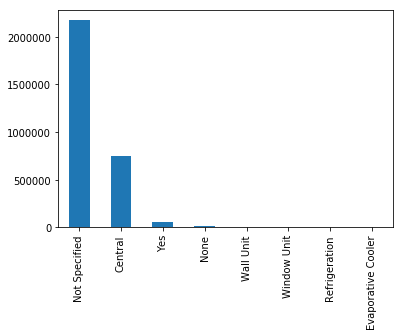

In [65]:
properties.AirConditioningDesc.value_counts().plot(kind='bar')

#### End of properties file exploration.